## import

In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.trainer import MultiOutputClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.pspnet import PSPLoss, PSPNet
from torchlake.semantic_segmentation.models.deeplabv2 import deeplab_v2_style_resnet
from tqdm import tqdm

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/pspnet")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 224

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)

In [6]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)


In [7]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

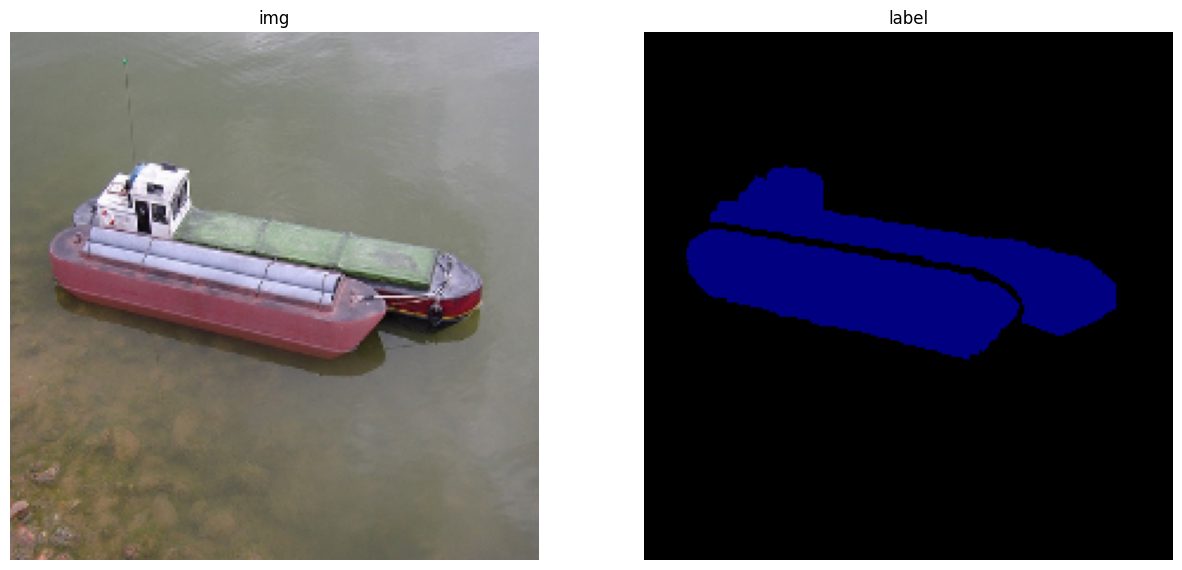

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [10]:
backbone = deeplab_v2_style_resnet("resnet50", trainable=True)
model = PSPNet(backbone, output_size=NUM_CLASS + 1).to(DEVICE)

In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
PSPNet                                                  --
├─ResNetFeatureExtractor: 1-1                           --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2d: 3-1                                 9,408
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             215,808
│    │    └─Sequential: 3-6                             1,219,584
│    │    └─Sequential: 3-7                             7,098,368
│    │    └─Sequential: 3-8                             14,964,736
│    └─ImageNetNormalization: 2-2                       --
├─Sequential: 1-2                                       --
│    └─PyramidPool2d: 2-3                               --
│    │    └─ModuleList: 3-9                             4,198,400
├─Sequential:

# train

In [12]:
EPOCHS = 30

In [13]:
trainer = MultiOutputClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [14]:
criterion = PSPLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [15]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 182/182 [01:03<00:00,  2.89it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.2110e-01 (0.00%)


100%|██████████| 182/182 [01:14<00:00,  2.46it/s]


------------------------------------
Epoch 2
------------------------------------
total: 8.0729e-02 (-33.00%)


100%|██████████| 182/182 [01:26<00:00,  2.10it/s]


------------------------------------
Epoch 3
------------------------------------
total: 6.9068e-02 (-14.00%)


100%|██████████| 182/182 [01:06<00:00,  2.75it/s]


------------------------------------
Epoch 4
------------------------------------
total: 6.2528e-02 (-9.00%)


100%|██████████| 182/182 [01:25<00:00,  2.14it/s]


------------------------------------
Epoch 5
------------------------------------
total: 5.8748e-02 (-6.00%)


100%|██████████| 182/182 [01:27<00:00,  2.07it/s]


------------------------------------
Epoch 6
------------------------------------
total: 5.5962e-02 (-5.00%)


100%|██████████| 182/182 [01:29<00:00,  2.03it/s]


------------------------------------
Epoch 7
------------------------------------
total: 5.3510e-02 (-4.00%)


100%|██████████| 182/182 [01:16<00:00,  2.37it/s]


------------------------------------
Epoch 8
------------------------------------
total: 5.0865e-02 (-5.00%)


100%|██████████| 182/182 [01:09<00:00,  2.64it/s]


------------------------------------
Epoch 9
------------------------------------
total: 4.8743e-02 (-4.00%)


100%|██████████| 182/182 [01:19<00:00,  2.29it/s]


------------------------------------
Epoch 10
------------------------------------
total: 4.9512e-02 (2.00%)


100%|██████████| 182/182 [01:10<00:00,  2.57it/s]


------------------------------------
Epoch 11
------------------------------------
total: 4.7127e-02 (-5.00%)


100%|██████████| 182/182 [01:15<00:00,  2.42it/s]


------------------------------------
Epoch 12
------------------------------------
total: 4.6001e-02 (-2.00%)


100%|██████████| 182/182 [00:56<00:00,  3.21it/s]


------------------------------------
Epoch 13
------------------------------------
total: 4.5028e-02 (-2.00%)


100%|██████████| 182/182 [00:56<00:00,  3.22it/s]


------------------------------------
Epoch 14
------------------------------------
total: 4.3733e-02 (-3.00%)


100%|██████████| 182/182 [00:56<00:00,  3.21it/s]


------------------------------------
Epoch 15
------------------------------------
total: 4.3148e-02 (-1.00%)


100%|██████████| 182/182 [00:53<00:00,  3.40it/s]


------------------------------------
Epoch 16
------------------------------------
total: 4.2562e-02 (-1.00%)


100%|██████████| 182/182 [00:59<00:00,  3.06it/s]


------------------------------------
Epoch 17
------------------------------------
total: 4.2296e-02 (-1.00%)


100%|██████████| 182/182 [01:05<00:00,  2.80it/s]


------------------------------------
Epoch 18
------------------------------------
total: 4.1624e-02 (-2.00%)


100%|██████████| 182/182 [01:17<00:00,  2.36it/s]


------------------------------------
Epoch 19
------------------------------------
total: 4.0071e-02 (-4.00%)


100%|██████████| 182/182 [01:09<00:00,  2.61it/s]


------------------------------------
Epoch 20
------------------------------------
total: 3.9700e-02 (-1.00%)


100%|██████████| 182/182 [01:27<00:00,  2.09it/s]


------------------------------------
Epoch 21
------------------------------------
total: 3.8239e-02 (-4.00%)


100%|██████████| 182/182 [01:21<00:00,  2.23it/s]


------------------------------------
Epoch 22
------------------------------------
total: 3.7738e-02 (-1.00%)


100%|██████████| 182/182 [00:55<00:00,  3.25it/s]


------------------------------------
Epoch 23
------------------------------------
total: 3.7308e-02 (-1.00%)


100%|██████████| 182/182 [00:57<00:00,  3.16it/s]


------------------------------------
Epoch 24
------------------------------------
total: 3.5891e-02 (-4.00%)


100%|██████████| 182/182 [00:57<00:00,  3.16it/s]


------------------------------------
Epoch 25
------------------------------------
total: 3.6483e-02 (2.00%)


100%|██████████| 182/182 [01:07<00:00,  2.68it/s]


------------------------------------
Epoch 26
------------------------------------
total: 3.6050e-02 (-1.00%)


100%|██████████| 182/182 [01:22<00:00,  2.20it/s]


------------------------------------
Epoch 27
------------------------------------
total: 3.5575e-02 (-1.00%)


100%|██████████| 182/182 [01:21<00:00,  2.25it/s]


------------------------------------
Epoch 28
------------------------------------
total: 3.4720e-02 (-2.00%)


100%|██████████| 182/182 [01:24<00:00,  2.14it/s]


------------------------------------
Epoch 29
------------------------------------
total: 3.3474e-02 (-4.00%)


100%|██████████| 182/182 [01:24<00:00,  2.14it/s]

------------------------------------
Epoch 30
------------------------------------
total: 3.2842e-02 (-2.00%)


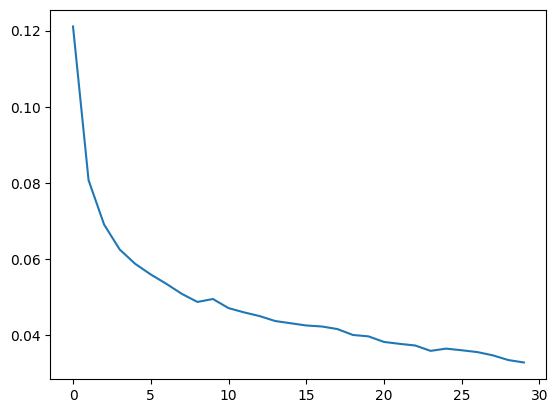

In [17]:
plt.plot(training_loss)
# plt.plot(torch.arange(len(training_loss)), torch.arange(len(training_loss)).mul(-0.05/2).exp())

In [12]:
model_path = artifacts_path.joinpath('pspnet.pth')

In [25]:
torch.save(model.state_dict(), model_path)

In [26]:
get_file_size(model_path)

'187.1MiB'

# inference

In [13]:
model.load_state_dict(torch.load(model_path), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['aux.0.0.weight', 'aux.0.1.weight', 'aux.0.1.bias', 'aux.0.1.running_mean', 'aux.0.1.running_var', 'aux.0.1.num_batches_tracked', 'aux.2.weight', 'aux.2.bias'])

In [23]:
# for inference, be cautious if you have not saved trained weights
if hasattr(model, "aux"):
    del model.aux

In [24]:
model_path = artifacts_path.joinpath('pspnet.inference.pth')

In [25]:
torch.save(model.state_dict(), model_path)

In [26]:
get_file_size(model_path)

'178.08MiB'

In [14]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [15]:
test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [16]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

### mIOU

In [17]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [18]:
evaluator = ClassificationEvaluator(NUM_CLASS + 1, DEVICE)

In [19]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 40/40 [00:11<00:00,  3.40it/s]


In [20]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.86 
bicycle        : 0.56 
bird           : 0.9  
boat           : 0.84 
bottle         : 0.88 
bus            : 0.93 
car            : 0.88 
cat            : 0.93 
chair          : 0.68 
cow            : 0.87 
diningtable    : 0.91 
dog            : 0.88 
horse          : 0.81 
motorbike      : 0.85 
person         : 0.88 
pottedplant    : 0.62 
sheep          : 0.89 
sofa           : 0.89 
train          : 0.92 
tvmonitor      : 0.9  
----------------------
total          : 0.84 


### for image in dataset

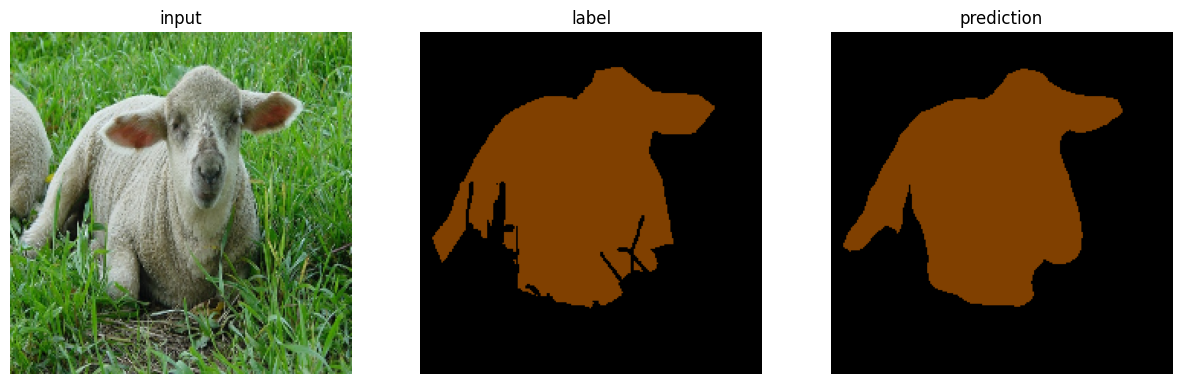

In [21]:
interest_pic = 11

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

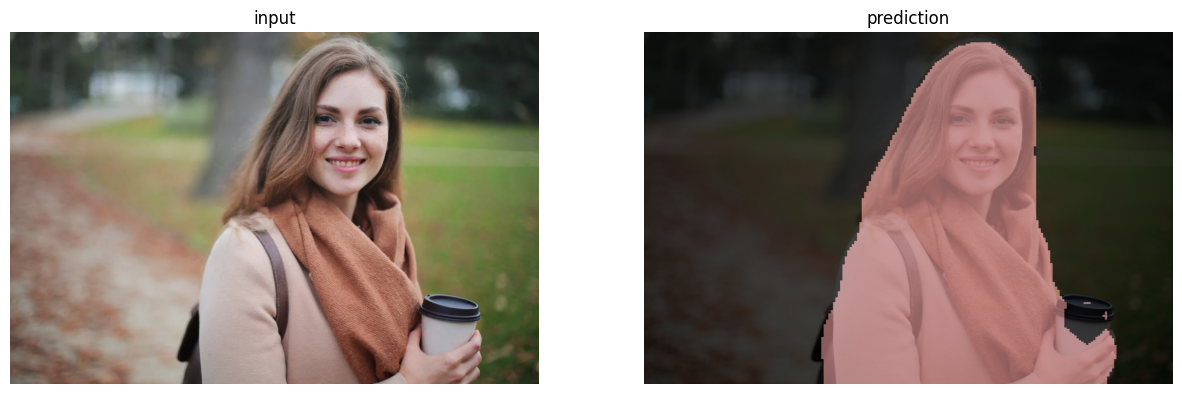

In [22]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )